# Deep Transfer Learning Type 3
Video Tutorial Lengkapnya: 

https://www.youtube.com/watch?v=PfrK0YEssBg&t=688s

In [ ]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import cv2
import pandas as pd
!git clone "https://gitlab.com/ykristian/dataset-bunga"
%cd dataset-bunga/
with open("DatasetBunga.p", "rb") as f:
  data = pickle.load(f)

Cloning into 'dataset-bunga'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8
Unpacking objects: 100% (8/8), done.
Checking out files: 100% (4/4), done.
/content/dataset-bunga


In [ ]:
imgdata = np.array(data["img_data"])
print(imgdata.shape)
labeldata = np.array(data["label_data"])
print(labeldata.shape)

(4323, 224, 224, 3)
(4323,)


3


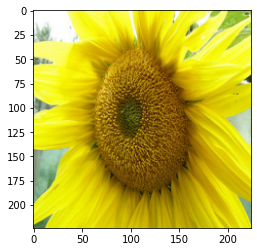

In [ ]:
print(labeldata[3154])
plt.imshow(imgdata[3154])
#LABEL 0=DAISY, 1=DANDELION, 2=ROSE, 3=SUNFLOWER, 4=TULIP

In [ ]:
X = imgdata
y = pd.get_dummies(labeldata)
print(y.shape)
print(y.sample(10))

(4323, 5)
      0  1  2  3  4
893   0  1  0  0  0
2304  0  0  1  0  0
3076  0  0  0  1  0
186   1  0  0  0  0
526   1  0  0  0  0
3757  0  0  0  0  1
516   1  0  0  0  0
3677  0  0  0  0  1
288   1  0  0  0  0
4216  0  0  0  0  1


In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1011)

print("X_train Shape:", X_train.shape)
print("X_val Shape:",X_test.shape)

print("y_train Shape:", y_train.shape)
print("y_val Shape:",y_test.shape)

X_train Shape: (3458, 224, 224, 3)
X_val Shape: (865, 224, 224, 3)
y_train Shape: (3458, 5)
y_val Shape: (865, 5)


In [ ]:
import keras
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.efficientnet_v2 import EfficientNetV2M
#Ubah bagian model menjadi Deep Conv Net untuk memperbaiki prediksinya

base_model = EfficientNetV2M(include_top = False, weights='imagenet', input_shape=(224,224,3))
base_model.summary()


214212608/214201816 [==============================] - 3s 0us/step
Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                

In [ ]:
from keras.layers import BatchNormalization
from keras import Model

inp = base_model.input
m = base_model.output
m = Flatten()(m)
m = Dense(200, activation='relu', name='fc1')(m)
m = BatchNormalization()(m)
m = Dropout(0.3)(m)
m = Dense(100, activation='relu', name='fc2')(m)
m = Dropout(0.3)(m)
m = Dense(50, activation='relu', name='fc3')(m)
predictions = Dense(5, activation='softmax', name='pred')(m)
# this is the model we will train
model_new = Model(inputs=base_model.input, outputs=predictions)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
for layer in model_new.layers:
  if layer.name == 'block7e_dwconv2':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
model_new.summary()

Layer input_1 frozen.
Layer rescaling frozen.
Layer stem_conv frozen.
Layer stem_bn frozen.
Layer stem_activation frozen.
Layer block1a_project_conv frozen.
Layer block1a_project_bn frozen.
Layer block1a_project_activation frozen.
Layer block1a_add frozen.
Layer block1b_project_conv frozen.
Layer block1b_project_bn frozen.
Layer block1b_project_activation frozen.
Layer block1b_add frozen.
Layer block1c_project_conv frozen.
Layer block1c_project_bn frozen.
Layer block1c_project_activation frozen.
Layer block1c_add frozen.
Layer block2a_expand_conv frozen.
Layer block2a_expand_bn frozen.
Layer block2a_expand_activation frozen.
Layer block2a_project_conv frozen.
Layer block2a_project_bn frozen.
Layer block2b_expand_conv frozen.
Layer block2b_expand_bn frozen.
Layer block2b_expand_activation frozen.
Layer block2b_project_conv frozen.
Layer block2b_project_bn frozen.
Layer block2b_add frozen.
Layer block2c_expand_conv frozen.
Layer block2c_expand_bn frozen.
Layer block2c_expand_activation f

In [ ]:
from keras.optimizers import adam_v2

opt = adam_v2.Adam(0.0003, beta_1=0.9, beta_2=0.999, amsgrad=True)
model_new.compile(optimizer=opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
h = model_new.fit(X_train, y_train, epochs=10, validation_data = (X_test, y_test), batch_size=50, verbose=1, shuffle=1)

Epoch 1/10
70/70 [==============================] - 75s 483ms/step - loss: 0.6045 - accuracy: 0.7817 - val_loss: 0.3376 - val_accuracy: 0.8809
Epoch 2/10
70/70 [==============================] - 33s 469ms/step - loss: 0.2225 - accuracy: 0.9303 - val_loss: 0.2619 - val_accuracy: 0.9087
Epoch 3/10
70/70 [==============================] - 28s 402ms/step - loss: 0.1217 - accuracy: 0.9667 - val_loss: 0.2459 - val_accuracy: 0.9225
Epoch 4/10
70/70 [==============================] - 28s 406ms/step - loss: 0.0596 - accuracy: 0.9853 - val_loss: 0.2691 - val_accuracy: 0.9249
Epoch 5/10
70/70 [==============================] - 29s 410ms/step - loss: 0.0300 - accuracy: 0.9913 - val_loss: 0.3154 - val_accuracy: 0.9133
Epoch 6/10
70/70 [==============================] - 29s 421ms/step - loss: 0.0404 - accuracy: 0.9881 - val_loss: 0.3526 - val_accuracy: 0.9087
Epoch 7/10
70/70 [==============================] - 29s 420ms/step - loss: 0.0317 - accuracy: 0.9910 - val_loss: 0.3157 - val_accuracy: 0.9098

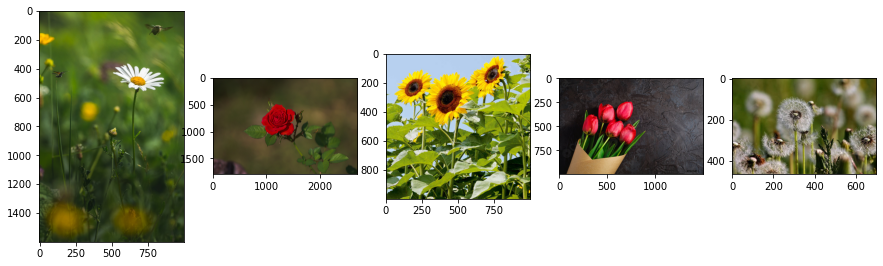

(5, 224, 224, 3)


In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import requests

urls = [
    "https://images.unsplash.com/photo-1560330056-a797fa57599a?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MjF8fGRhaXN5fGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80",
    "https://images.unsplash.com/photo-1622569682605-b03a22ec5acb?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2700&q=80",
    "https://dobies-liquid.s3-eu-west-1.amazonaws.com/p/xl/FLSSUN30353.jpg?ts=1605616296",
    "https://www.crushpixel.com/big-static17/preview4/bouquet-red-tulip-flowers-on-2609411.jpg",
    "https://asset-a.grid.id/crop/0x0:0x0/700x465/photo/2021/10/22/bunga-dandelionjpg-20211022055320.jpg"
]

imgs=[]
plt.figure(figsize=(15,6))
for u in range(0,len(urls)):
  r = requests.get(urls[u], stream=True)
  img = np.array(Image.open(r.raw))
  plt.subplot(1,len(urls),u+1)
  plt.imshow(img)
  #resize to same size before appending to imgs so we can maintain np array dimension
  img = cv2.resize(img, (224,224))
  imgs.append(img)
plt.show()

imgs = np.array(imgs)
print (imgs.shape)

In [ ]:
#Predic the downloaded images 
yhat=model_new.predict(imgs)
for i in range(len(urls)):
  if(np.argmax(yhat[i]) == 0):
      print("Daisy")
  elif(np.argmax(yhat[i]) == 1):
      print("Dandelion")
  elif(np.argmax(yhat[i]) == 2):
      print("Rose")
  elif(np.argmax(yhat[i]) == 3):
      print("Sunflower")
  elif(np.argmax(yhat[i]) == 4):
      print("Tulip")
  

Daisy
Rose
Sunflower
Rose
Dandelion


In [ ]:
model_new.save("m.hdf5")